<a href="https://www.kaggle.com/code/tousifbnn/oasis-alzheimer-s-detection-cnn?scriptVersionId=235837711" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Balanced dataset size: 1952
n_estimators: 10
Train Accuracy: 100.00%
Val Accuracy: 100.00%
n_estimators: 30
Train Accuracy: 100.00%
Val Accuracy: 100.00%
n_estimators: 50
Train Accuracy: 100.00%
Val Accuracy: 100.00%
n_estimators: 70
Train Accuracy: 100.00%
Val Accuracy: 100.00%
n_estimators: 90
Train Accuracy: 100.00%
Val Accuracy: 100.00%
n_estimators: 100
Train Accuracy: 100.00%
Val Accuracy: 100.00%


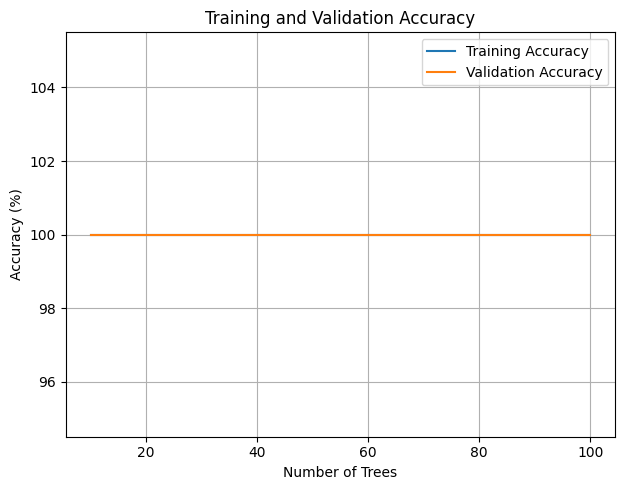

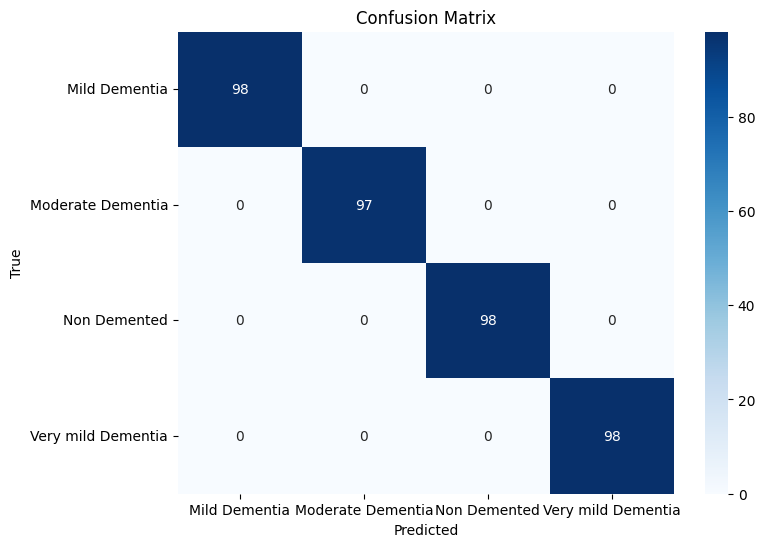


Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00        98
 Moderate Dementia       1.00      1.00      1.00        97
      Non Demented       1.00      1.00      1.00        98
Very mild Dementia       1.00      1.00      1.00        98

          accuracy                           1.00       391
         macro avg       1.00      1.00      1.00       391
      weighted avg       1.00      1.00      1.00       391



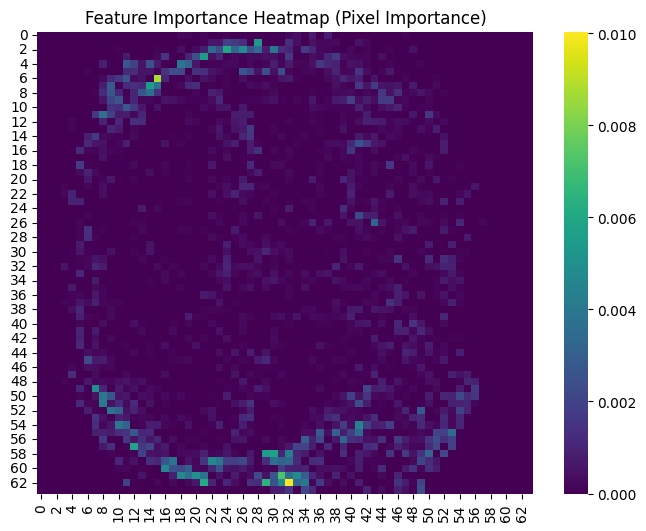

['rf_alzheimer_4classes.pkl']

In [1]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os

# Copy dataset to working directory for faster I/O
data_dir = '/kaggle/input/imagesoasis/Data'
working_dir = '/kaggle/working/oasis_data'
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
data_dir = working_dir

# Transforms with grayscale conversion
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
original_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = original_dataset.classes
class_to_idx = original_dataset.class_to_idx

# Use all 4 classes
num_classes = len(class_names)
print("Classes:", class_names)
assert num_classes == 4, f"Expected 4 classes, got {num_classes}"

# Balance the dataset (488 images per class)
indices_per_class = {i: [] for i in range(num_classes)}
for idx, label in enumerate(original_dataset.targets):
    indices_per_class[label].append(idx)

# Take 488 samples per class
balanced_indices = []
balanced_labels = []
for label in range(num_classes):
    selected_indices = indices_per_class[label][:488]  # Limit to 488 per class
    balanced_indices.extend(selected_indices)
    balanced_labels.extend([label] * len(selected_indices))

print("Balanced dataset size:", len(balanced_indices))

# Prepare data for Random Forest (flatten images)
# Fix: Remove redundant transform, as images are already transformed
X = np.array([original_dataset[i][0].flatten().numpy() for i in balanced_indices])
y = np.array(balanced_labels)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=balanced_labels, random_state=42
)

# Random Forest Model
# Simulate "epochs" by incrementally increasing the number of trees
n_estimators_list = [10, 30, 50, 70, 90, 100]  # Simulate 6 "epochs"
train_accuracies = []
val_accuracies = []

for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Training accuracy
    train_pred = rf.predict(X_train)
    train_accuracy = 100 * (train_pred == y_train).mean()
    train_accuracies.append(train_accuracy)
    
    # Validation accuracy
    val_pred = rf.predict(X_val)
    val_accuracy = 100 * (val_pred == y_val).mean()
    val_accuracies.append(val_accuracy)
    
    print(f"n_estimators: {n_estimators}")
    print(f'Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Accuracy: {val_accuracy:.2f}%')

# Final model with all trees
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
val_pred = rf.predict(X_val)

# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_estimators_list, train_accuracies, label='Training Accuracy')
plt.plot(n_estimators_list, val_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history_rf_4classes.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_rf_4classes.png', dpi=300, bbox_inches='tight')
plt.show()

# Class-wise metrics
print("\nClassification Report:")
print(classification_report(y_val, val_pred, target_names=class_names))

# Feature Importance
feature_importance = rf.feature_importances_
importance_map = feature_importance.reshape(64, 64)
plt.figure(figsize=(8, 6))
sns.heatmap(importance_map, cmap='viridis')
plt.title('Feature Importance Heatmap (Pixel Importance)')
plt.savefig('feature_importance_rf_4classes.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
import joblib
joblib.dump(rf, 'rf_alzheimer_4classes.pkl')